# 02 - HSV Parameter Tuning
Interactive notebook for optimizing HSV detection parameters.

In [1]:
import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from pathlib import Path

%matplotlib inline

## 1. Load Frame

In [14]:
VIDEO_PATH = '../data/videos/input/1.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, 85)  # jump to frame 69
ret, frame = cap.read()
cap.release()

if ret:
    print(f"Frame loaded: {frame.shape}")
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
else:
    print("Error loading frame")

Frame loaded: (1080, 1908, 3)


## 2. Visualize HSV Channels

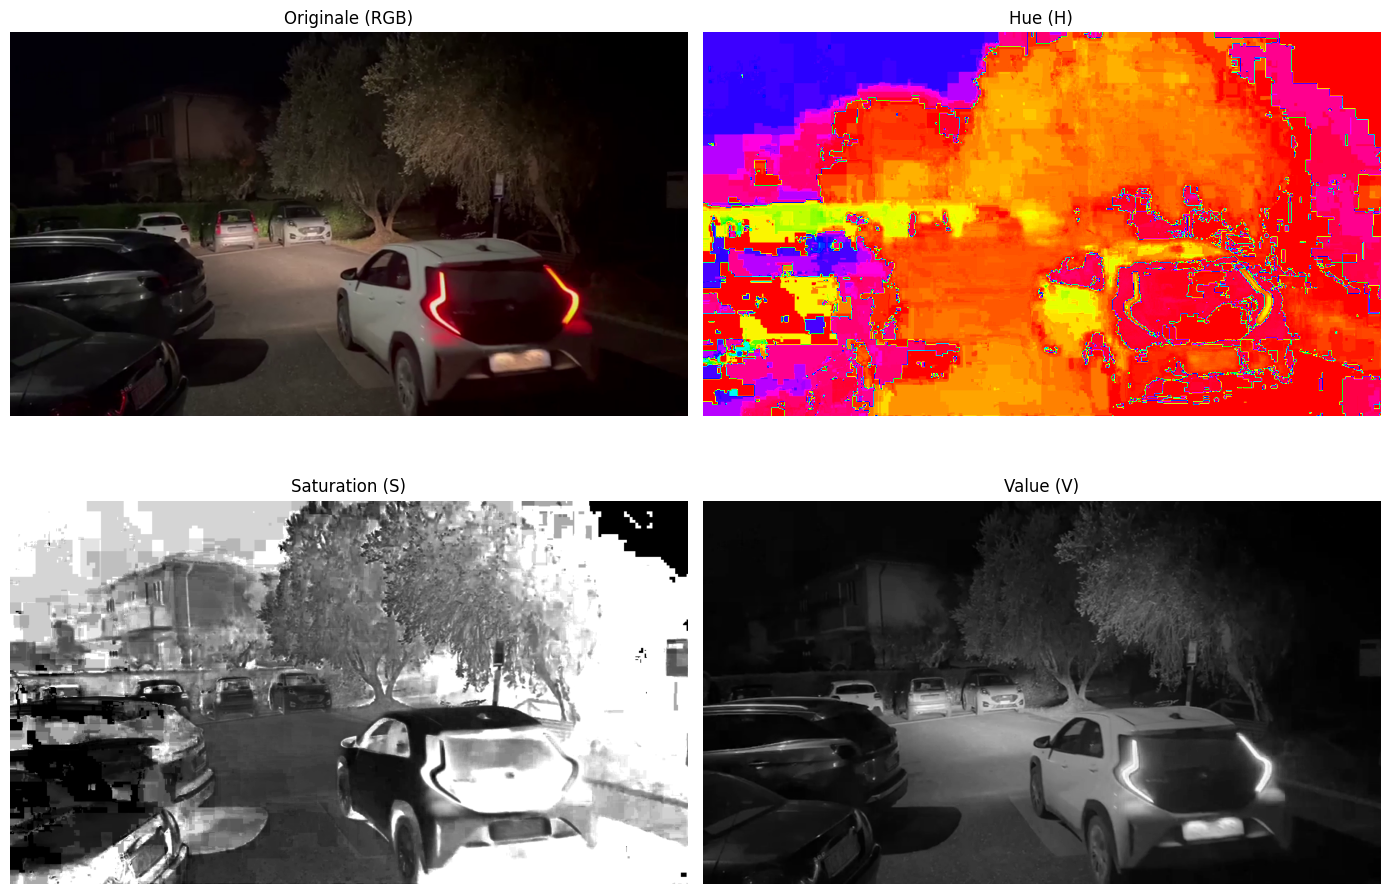


Statistiche HSV:
  H range: [0, 179]
  S range: [0, 255]
  V range: [0, 255]


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Originale (RGB)')
axes[0, 0].axis('off')

axes[0, 1].imshow(hsv_frame[:,:,0], cmap='hsv')
axes[0, 1].set_title('Hue (H)')
axes[0, 1].axis('off')

axes[1, 0].imshow(hsv_frame[:,:,1], cmap='gray')
axes[1, 0].set_title('Saturation (S)')
axes[1, 0].axis('off')

axes[1, 1].imshow(hsv_frame[:,:,2], cmap='gray')
axes[1, 1].set_title('Value (V)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\nStatistiche HSV:")
print(f"  H range: [{hsv_frame[:,:,0].min()}, {hsv_frame[:,:,0].max()}]")
print(f"  S range: [{hsv_frame[:,:,1].min()}, {hsv_frame[:,:,1].max()}]")
print(f"  V range: [{hsv_frame[:,:,2].min()}, {hsv_frame[:,:,2].max()}]")

## 3. Interactive Red Range Tuning

In [8]:
# =========================
# CELL 6 - INTERACTIVE PARAMETER TUNING
# =========================
# Use the sliders to find the right thresholds on a sample frame.
# Once the detection looks good, copy the values into config above.

from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
%matplotlib inline

# Load a sample frame from the middle of the video
VIDEO_DIR = '/app/data/videos/input/'
videos = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi', '.mov'))]
VIDEO_PATH = os.path.join(VIDEO_DIR, videos[0])

cap = cv2.VideoCapture(VIDEO_PATH)
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, total // 2)
ret, sample_frame = cap.read()
cap.release()

if not ret:
    print("Cannot load sample frame")
else:
    def tune_detection(V_lower, V_plate_low, V_plate_high, min_area_ratio_x10000):
        """
        Live preview of detection with current slider values.
        Top row: lights mask + detected light centers
        Bottom row: plate ROI + detected plate corners
        """
        config_tune = {
            'V_LOWER':                V_lower,
            'MAX_Y_RATIO':            0.80,
            'MIN_VERTICAL_RATIO':     1.2,
            'MIN_CONTOUR_AREA_RATIO': min_area_ratio_x10000 / 10000.0,
            'Y_TOLERANCE':            5,
            'V_PLATE_LOW':            V_plate_low,
            'V_PLATE_HIGH':           V_plate_high,
        }

        frame = sample_frame.copy()
        height, width = frame.shape[:2]

        # --- Lights mask ---
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        V   = hsv[:, :, 2]
        mask = cv2.inRange(V, V_lower, 255)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 9))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel)

        # --- Run full detection ---
        success, fari, extremes, plate_corners, _, _ = detect_headlights_and_plate(frame, config_tune)

        # --- Draw on frame ---
        vis = frame.copy()
        if success:
            for pt in fari:
                cv2.circle(vis, pt, 10, (0, 255, 255), -1)
            for pt in extremes.values():
                cv2.circle(vis, pt, 7, (255, 0, 0), -1)
            if plate_corners:
                poly = np.array([
                    plate_corners['TL'], plate_corners['TR'],
                    plate_corners['BR'], plate_corners['BL']
                ], dtype=np.int32)
                cv2.polylines(vis, [poly], True, (0, 255, 0), 2)
                for name, pt in plate_corners.items():
                    cv2.putText(vis, name, (pt[0]+4, pt[1]-4),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # --- Plot ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        axes[0].imshow(mask, cmap='gray')
        axes[0].set_title(f'Lights mask  (V_lower={V_lower})')
        axes[0].axis('off')

        status = 'OK' if success else 'FAILED'
        color_title = 'green' if success else 'red'
        axes[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Detection: {status}  |  plate_low={V_plate_low}  plate_high={V_plate_high}',
                          color=color_title)
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        if success:
            print(f"Lights:  {fari}")
            print(f"Plate corners: {plate_corners}")
        else:
            print("Detection failed — adjust sliders")

    interact(
        tune_detection,
        V_lower         = IntSlider(min=100, max=255, step=5,  value=210, description='V lights',      continuous_update=False),
        V_plate_low     = IntSlider(min=50,  max=255, step=5,  value=150, description='V plate min',   continuous_update=False),
        V_plate_high    = IntSlider(min=100, max=255, step=5,  value=240, description='V plate max',   continuous_update=False),
        min_area_ratio_x10000 = IntSlider(min=1, max=20, step=1, value=2, description='Min area x10k', continuous_update=False),
    )

interactive(children=(IntSlider(value=210, continuous_update=False, description='V lights', max=255, min=100, …